In [1]:
import torch
from torch import Tensor
from torch.nn import Linear, MSELoss, functional as F
from torch.optim import SGD
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# This file trains neural networks and validate test accuracy using extracted features on ASVspoof 2017 dataset

In [3]:
# load data
data_path = ".\data"

# each row is a sample
# label 1 for genuine data, 0 for recorded data
with open(os.path.join(data_path,'combined_void_phoneme_training_features.npy'), 'rb') as f:
    features = np.load(f)
with open(os.path.join(data_path,'training_labels.npy'), 'rb') as f:
    labels = np.load(f)

In [4]:
# standardization
scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=19)

# convert into tensor
X=torch.from_numpy(X_train).float().to(device)
y=torch.from_numpy(y_train).to(device)
Xtest=torch.from_numpy(X_test).float().to(device)
ytest=torch.from_numpy(y_test).to(device)

In [5]:
# define neural networks

# This is a basic 2-layer fully connected network
# It should be broad to push it into overparameterization regime
# best parameters so far: 50000 hidden neurons, 1e-2 learning rate, 99.2% test accuracy
# 70000 hidden neurons give 100% training accuracy, but test accuracy is 99.1%
# 50000 hidden neurons should be sufficient overparameterization

# N is number of samples; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H).to(device)
        self.linear2 = torch.nn.Linear(H, D_out).to(device)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        y_pred = self.linear2(x)
        return y_pred
    
    
class TenLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TenLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H).to(device)
        self.linear2 = torch.nn.Linear(H, H).to(device)
        self.linear3 = torch.nn.Linear(H, H).to(device)
        self.linear4 = torch.nn.Linear(H, H).to(device)
        self.linear5 = torch.nn.Linear(H, H).to(device)
        self.linear6 = torch.nn.Linear(H, H).to(device)
        self.linear7 = torch.nn.Linear(H, H).to(device)
        self.linear8 = torch.nn.Linear(H, H).to(device)
        self.linear9 = torch.nn.Linear(H, H).to(device)
        self.linear10 = torch.nn.Linear(H, D_out).to(device)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.relu(self.linear3(x))
        x = self.dropout(x)
        x = self.relu(self.linear4(x))
        x = self.dropout(x)
        x = self.relu(self.linear5(x))
        x = self.dropout(x)
        x = self.relu(self.linear6(x))
        x = self.dropout(x)
        x = self.relu(self.linear7(x))
        x = self.dropout(x)
        x = self.relu(self.linear8(x))
        x = self.dropout(x)
        x = self.relu(self.linear9(x))
        x = self.dropout(x)
        y_pred = self.linear10(x)
        return y_pred

In [6]:
# N is number of samples; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
def run(H=2000, learning_rate = 1e-3, num_epochs = 10000, 
        report_test_loss = True, NN_type = "TwoLayerNet", verbose = True, x=None, y =None, x_test = None, 
        y_test=None, weight_decay=0, batch_size = 64):

    D_in = x.shape[1]
    
    loss_training = []
    loss_test = []
    acc_training = []
    acc_test = []
    
    # Construct our model by instantiating the class defined above
    if NN_type == "TenLayerNet":
        model = TenLayerNet(D_in, H, 1)
    elif NN_type == "TwoLayerNet":
        model = TwoLayerNet(D_in, H, 1)
    model.to(device)

    # loss function and an Optimizer
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    #     training
    for t in range(num_epochs):
        # test accuracy
        if report_test_loss:
            y_pred = model(x_test)
            y_pred_tag = torch.round(torch.sigmoid(y_pred))
            acc = (y_pred_tag == y_test).sum().float()/y_test.shape[0]* 100
            acc_test.append(acc.item())
            optimizer.zero_grad()

        # Forward pass. feed data
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y.float())

        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        acc = (y_pred_tag == y).sum().float()/y.shape[0]* 100
        acc_training.append(acc.item())
        #         loss_training.append(loss.item())
        if verbose and t % 500 == 499:
            print(t, acc.item())
            if report_test_loss:
                print("test", acc_test[-1])

        # backward pass. update weights based on gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #   plot results
    epochs = range(0, num_epochs)
    plt.yscale("log")
    plt.plot(epochs, acc_training, 'b', label="training acc")
    if report_test_loss:
        plt.plot(epochs, acc_test, 'r', label="test acc")
    plt.legend(loc="upper right")
    plt.show()
    
    if report_test_loss:
        print(acc_test[-1])
    print(acc_training[-1])
    
    return loss_training, loss_test, acc_training, acc_test

99 56.42485046386719
199 66.00284576416016
299 72.9255599975586
399 76.90848541259766
499 79.65860748291016
599 80.79658508300781
699 82.12423706054688
799 83.73637390136719
899 84.49502563476562
999 84.11569213867188
1099 84.7795181274414
1199 84.82693481445312
1299 85.87007904052734
1399 86.9132308959961
1499 86.5813217163086
1599 85.82266235351562
1699 86.96064758300781
1799 87.90896606445312
1899 87.19772338867188
1999 87.52963256835938
2099 87.67189025878906
2199 88.09862518310547
2299 89.04694366455078
2399 88.71503448486328
2499 87.43480682373047
2599 88.62020111083984
2699 88.99952697753906
2799 88.99952697753906
2899 89.04694366455078
2999 89.47368621826172
3099 90.18492889404297
3199 90.13751220703125
3299 90.18492889404297
3399 90.27975463867188
3499 90.51683807373047
3599 90.42200469970703
3699 90.6590805053711
3799 91.03841400146484
3899 90.84874725341797
3999 90.89615631103516
4099 91.79706573486328
4199 90.9435806274414
4299 91.37032318115234
4399 91.18065643310547
4499 

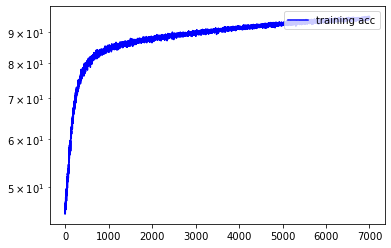

94.78425598144531


In [8]:
# running the training
results = {}


weight_decay=1e-2
num_epochs = 7000
H = 400
learning_rate = 1e-3


loss_training, loss_test, acc_training, acc_test = run(H=H, learning_rate = learning_rate, num_epochs = num_epochs, 
        report_test_loss = False, NN_type = "TwoLayerNet", verbose = True, x=X, y =y, x_test = Xtest, 
        y_test=ytest, weight_decay=weight_decay, batch_size = 64)

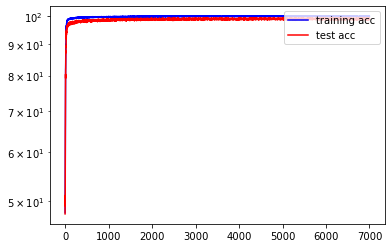

99.11601257324219
100.0


NameError: name 'results' is not defined

In [7]:
params = [("TwoLayerNet", 1e-2)]
Hs = [70000]

weight_decay=1e-4
num_epochs = 7000

for NN_type, learning_rate in params:
    for H in Hs:
        loss_training, loss_test, acc_training, acc_test = run(H=H, learning_rate = learning_rate, num_epochs = num_epochs, 
            report_test_loss = True, NN_type = NN_type, verbose = False, x=X, y =y, x_test = Xtest, 
            y_test=ytest, weight_decay=weight_decay, batch_size = 64)
        results[(NN_type, learning_rate)] = (loss_training, loss_test, acc_training, acc_test)

In [19]:
import pickle
a_file = open("results.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [ ]:
params = [("TenLayerNet", 1e-2)]
Hs = [5000]

weight_decay=1e-4
num_epochs = 30000

for NN_type, learning_rate in params:
    for H in Hs:
        loss_training, loss_test, acc_training, acc_test = run(H=H, learning_rate = learning_rate, num_epochs = num_epochs, 
            report_test_loss = True, NN_type = NN_type, verbose = True, x=X, y =y, x_test = Xtest, 
            y_test=ytest, weight_decay=weight_decay, batch_size = 64)
        results[(NN_type, learning_rate)] = (loss_training, loss_test, acc_training, acc_test)